Original dataset shape: (10000, 11)
After scaling, mean price (M$): 2.5229758819999994


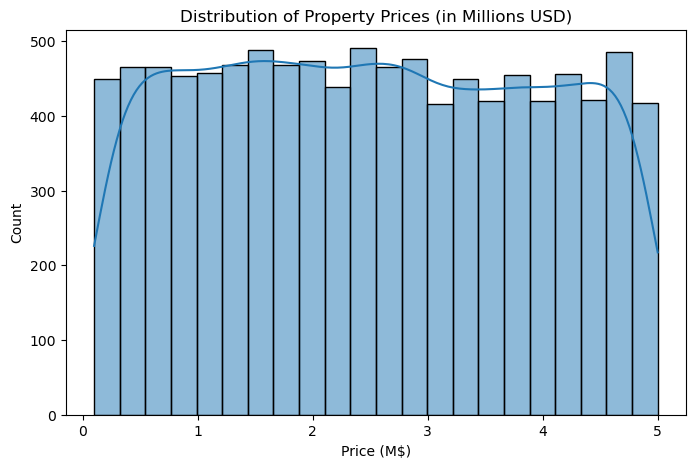

C:\Users\soham\AppData\Local\Temp\ipykernel_8768\530488980.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')


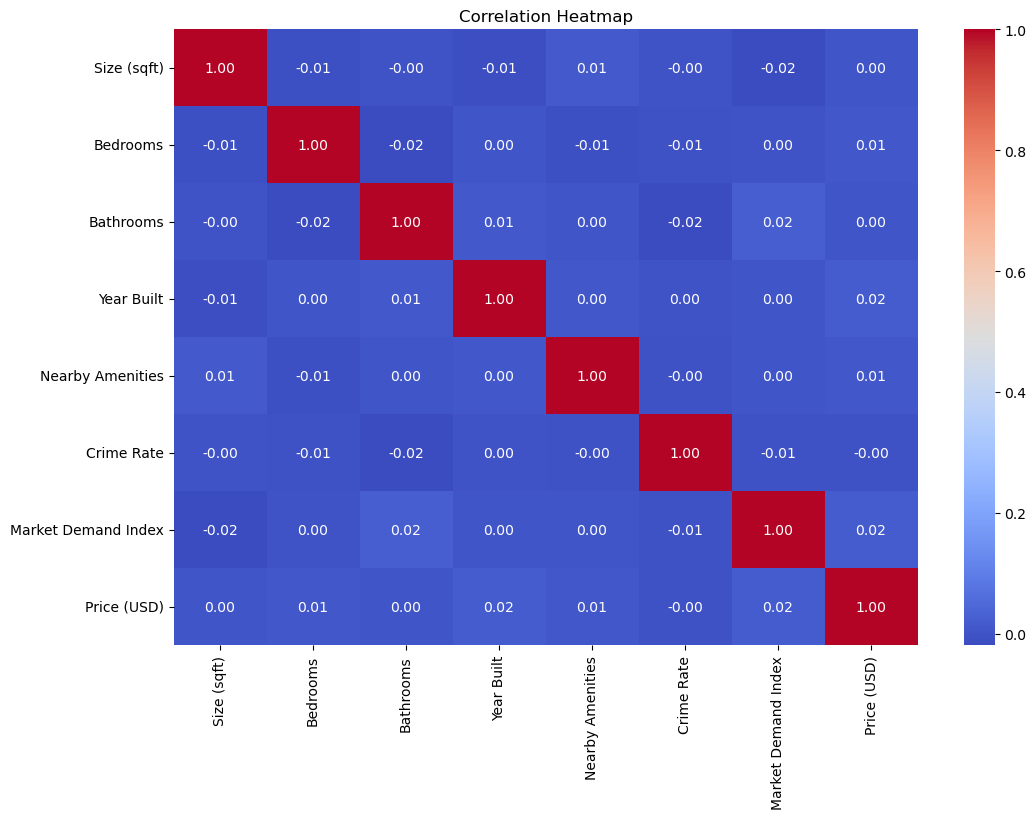

Tuning LinearRegression...
Tuning Ridge...
Tuning Lasso...
Tuning DecisionTree...
Tuning RandomForest...
Tuning GradientBoosting...
                  MAE (M$) MSE (M$²) RMSE (M$)  \
LinearRegression  1.225245  2.005465  1.416144   
Ridge             1.225217  2.005362  1.416108   
Lasso               1.2222  1.995083  1.412474   
DecisionTree      1.233269  2.047183  1.430798   
RandomForest      1.221454  1.997009  1.413156   
GradientBoosting   1.22182  1.996458  1.412961   

                                                        Best Params  
LinearRegression                                                 {}  
Ridge                                        {'model__alpha': 10.0}  
Lasso                                         {'model__alpha': 0.1}  
DecisionTree                                {'model__max_depth': 5}  
RandomForest      {'model__max_depth': 5, 'model__n_estimators':...  
GradientBoosting  {'model__learning_rate': 0.01, 'model__max_dep...  


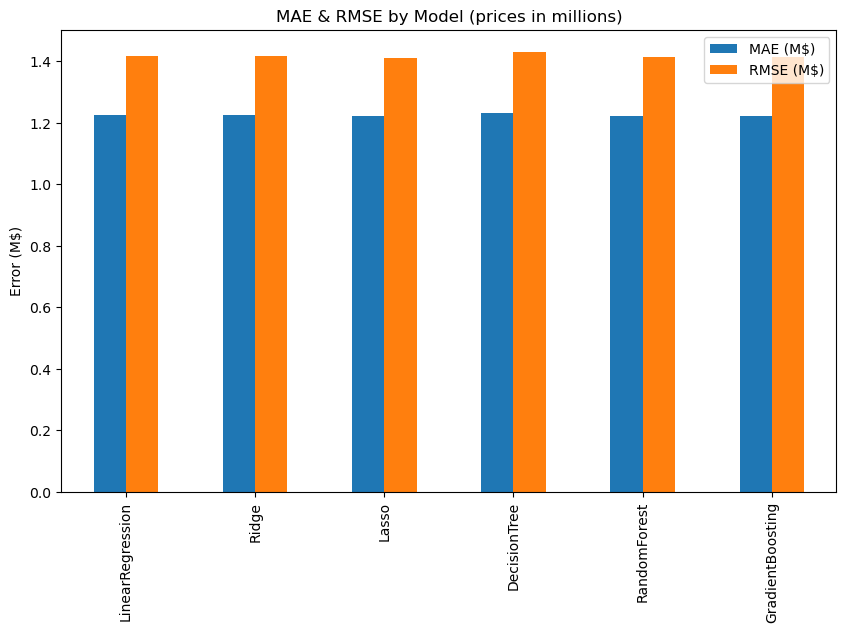

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data
df = pd.read_csv(r"D:\Documents\Sem_3\IS733\Project\real_estate_data_california.csv")
print("Original dataset shape:", df.shape)

# --- SCALE TARGET TO MILLIONS ---
df['Price (USD)'] = df['Price (USD)'] / 1e6
print("After scaling, mean price (M$):", df['Price (USD)'].mean())

# 2. EDA
plt.figure(figsize=(8, 5))
sns.histplot(df['Price (USD)'], kde=True)
plt.title('Distribution of Property Prices (in Millions USD)')
plt.xlabel('Price (M$)')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 3. Preprocessing
numeric_features = ['Size (sqft)', 'Bedrooms', 'Bathrooms', 'Year Built',
                    'Nearby Amenities', 'Crime Rate', 'Market Demand Index']
categorical_features = ['Location', 'Property Type', 'Condition']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 4. Split data
X = df.drop('Price (USD)', axis=1)
y = df['Price (USD)']   # now in millions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 5. Models & hyper‐parameters
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.01, 0.1, 1.0]},
    'DecisionTree': {'model__max_depth': [None, 5, 10]},
    'RandomForest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 5, 10]
    },
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

# 6. Fit, tune, evaluate
results = {}
for name, estimator in models.items():
    pipe = Pipeline(steps=[('preproc', preprocessor),
                           ('model', estimator)])
    search = GridSearchCV(pipe,
                          param_grid=param_grids[name],
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)
    print(f"Tuning {name}...")
    search.fit(X_train, y_train)
    best = search.best_estimator_
    y_pred = best.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    results[name] = {
        'MAE (M$)': mae,
        'MSE (M$²)': mse,
        'RMSE (M$)': rmse,
        'Best Params': search.best_params_
    }

# 7. Report
results_df = pd.DataFrame(results).T
print(results_df)

# 8. Plot MAE & RMSE
results_df[['MAE (M$)', 'RMSE (M$)']] \
    .plot(kind='bar', figsize=(10, 6),
          title='MAE & RMSE by Model (prices in millions)')
plt.ylabel('Error (M$)')
plt.show()
